## 0. Описание

Входные данные:
- Парсятся данные рыночных новостей из календаря
- Котировки загружаются из источника одномоментно

Проверяется связь влияния экономических показателей на волатильность и направление движения рынка.
На первом этапе формируется датасет. Затем проверяются дневные данные и связь с такими сущностями, как:
- номинальная сила (импакт из календаря) новости,
- валюта, по которой новость выходит
- общее число новостей в день

На втором этапе планируется переход к конкретным видам новостей и детализация исследуемого таймфрейма до часового (H1) или менье.

В качестве финальных результатов ожидается оценка реального влияния выходящих регулярных экономических показателей на волатильность и, возможно, направление движения.

In [4]:
import time
import pandas as pd
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## 1. Парсер календаря

* Парсим календарь экономических новостей по [ссылке](https://www.fxstreet.com/economic-calendar)
* Для работы с js-генерируемым содержимым используем Selenium
* Используем возможность выгрузки сформированного календаря в csv тоже через selenium (но в дальнейшем лучше спарсить данные напрямую без выгрузки, это позволяет получить больше данных и оправдывает использованием парсинга)

In [4]:
from selenium.webdriver import Chrome
from selenium.webdriver.support.ui import WebDriverWait

URL = 'https://www.fxstreet.com/economic-calendar'

In [5]:
bro = Chrome()

try:
    bro.get(URL)
    WebDriverWait(bro, timeout=10).until(lambda x: x.find_element_by_class_name('fxs_prestitial-continue'))

    # прокликиваем начальный баннер
    bro.find_element_by_class_name('fxs_prestitial-continue').click()

    # жмем на иконку календаря
    bro.find_element_by_class_name('fa-calendar-alt').click()

    #выбор начала периода (1.01.2020) - area begin календаря
    bro.find_element_by_xpath("//div[@class='fxs_c_datePicker_begin_calendar_area']/\
        select[@name='year']/option[text()='2020']").click()
    bro.find_element_by_xpath("//div[@class='fxs_c_datePicker_begin_calendar_area']/\
        select[@name='month']/option[text()='January']").click()
    #класс --start стоит внутри area begin как раз на первом числе месяца
    bro.find_element_by_xpath("//div[@class='fxs_c_datePicker_begin_calendar_area']/\
        div[@class='DayPicker-Day--start']").click()

    #выбор конца периода (31.12.2020) - area end календаря
    bro.find_element_by_xpath("//div[@class='fxs_c_datePicker_end_calendar_area']/\
        select[@name='year']/option[text()='2020']").click()
    bro.find_element_by_xpath("//div[@class='fxs_c_datePicker_end_calendar_area']/\
        select[@name='month']/option[text()='December']").click()
    #класс --end стоит внутри area begin как раз на последнем числе месяца
    bro.find_element_by_xpath("//div[@class='fxs_c_datePicker_end_calendar_area']/\
        div[@class='DayPicker-Day--end']").click()

    # часовой пояс устраивает, т.к. по умолчанию GMT, как и котировки

    # жмем на кнопку Apply
    bro.find_element_by_class('fxs_btn_cta').click()

    #ждем довольно долго через обычный слип, т.к. нужно время на формирование календаря за год
    time.sleep(50)

    # пользуемся кнопкой выгрузки в csv на календаре, жмем на нее и затем на формат CSV
    # (в идеале потом хотелось бы не через нее, т.к. часть данных теряется)
    bro.find_element_by_class_name('fa-download').click()
    bro.find_element_by_class_name('fa-file-csv').click()
except:
    print('Что-то пошло не так')

Данные загружаются в пользовательскую папку Загрузки. Название calendar-event-list.csv
Переносим его в /input, затем выгружаем в df и обрабатываем.
Оставляем при этом только новости, относящиеся к валютам EUR или USD, т.к. сравнивать будем с влиянием именно на пару EUR/USD.

In [5]:
news = pd.read_csv('input/calendar-event-list.csv')
news['datetime'] = pd.to_datetime(news['Start'])
news = news.drop(columns=['Start', 'Id'])
news.columns = ['title', 'impact', 'currency', 'datetime']
news = news[(news.currency=='EUR') | (news.currency=='USD')]
news = news.set_index('datetime')
news.head()

,title,impact,currency
datetime,,,
2020-01-01 05:00:00,New Year's Day,NONE,USD
2020-01-02 08:15:00,Markit Manufacturing PMI,LOW,EUR
2020-01-02 08:45:00,Markit Manufacturing PMI,LOW,EUR
2020-01-02 08:50:00,Markit Manufacturing PMI,LOW,EUR
2020-01-02 08:55:00,Markit Manufacturing PMI,MEDIUM,EUR


In [98]:
# проверка на пропуски
news.isnull().any()

title       False
impact      False
currency    False
dtype: bool

## 2. Получение котировок

Для данного исследования одномоментно закачиваются котировки EUR/USD в таймфрейме М1 за 2020 год (одна строка содержит данные о минутном баре в формате OHLC).

Источник котировок - [Dikascopy](https://www.dukascopy.com/swiss/russian/marketwatch/historical/)

In [6]:
%%time
quotes = pd.read_csv('input/eurusd_m1.csv')
quotes['date'] = pd.to_datetime(quotes['Gmt time'], format='%d.%m.%Y %H:%M:%S.000')
quotes = quotes.drop(columns=['Gmt time'])
quotes = quotes.set_index('date')
quotes.head()

Wall time: 1.78 s


,Open,High,Low,Close,Volume
date,,,,,
2020-01-01 00:00:00,1.12076,1.12076,1.12076,1.12076,0.0
2020-01-01 00:01:00,1.12076,1.12076,1.12076,1.12076,0.0
2020-01-01 00:02:00,1.12076,1.12076,1.12076,1.12076,0.0
2020-01-01 00:03:00,1.12076,1.12076,1.12076,1.12076,0.0
2020-01-01 00:04:00,1.12076,1.12076,1.12076,1.12076,0.0


## 3. Первичный анализ

В первичном анализе проведем группировку котировок по дням, расчитаем волатильность и направление. Затем выясним корреляцию расчитанных показателей и объема (Volume) в зависимости от:
- числа новостей в день,
- силы (impact) новости,
- вида (title) новости,
- валюты (currency), по которой выходит новость.

### 3.1 Подготовка котировок

In [7]:
# группируем минутки в данные по дням
ohlc_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last', 'Volume': 'sum'}
#d1 = quotes.set_index('date')
d1_quotes = quotes.resample('D').apply(ohlc_dict)
# волатильность - амплитуду движения за день - считаем в пунктах по 5-му знаку,
# умножая для этого на 10^5
d1_quotes['volatility'] = (abs(d1_quotes.High - d1_quotes.Low) * 10**5).astype(int)
# направление за день выразим в отношении к повышению
# это True, если день закрылся выше открытия; False, если нет
d1_quotes['uptrend'] = d1_quotes.Close > d1_quotes.Open
d1_quotes.head()

,Open,High,Low,Close,Volume,volatility,uptrend
date,,,,,,,
2020-01-01,1.12076,1.12218,1.12076,1.12188,2592.0700,141,True
2020-01-02,1.12188,1.12245,1.11635,1.11708,487219.1160,609,False
2020-01-03,1.11707,1.11798,1.11249,1.11548,177406.7897,548,False
2020-01-04,1.11548,1.11548,1.11548,1.11548,0.0000,0,False
2020-01-05,1.11548,1.11677,1.11548,1.11604,4398.1000,129,True


Посмотрим на распределение волатильности

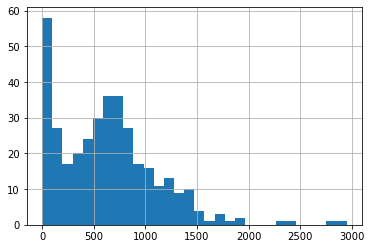

In [8]:
d1_quotes.volatility.hist(bins=30)

* пик в начале означает, что довольно большое кол-во дней обладают околонулевой волатильностью
* далее данные роаспределены более "нормально", следующий пик показывает, что большая часть дней имеет волатильность в диапазоне 600-800 пунктов

Посмотрим на изменение волатильности во времени

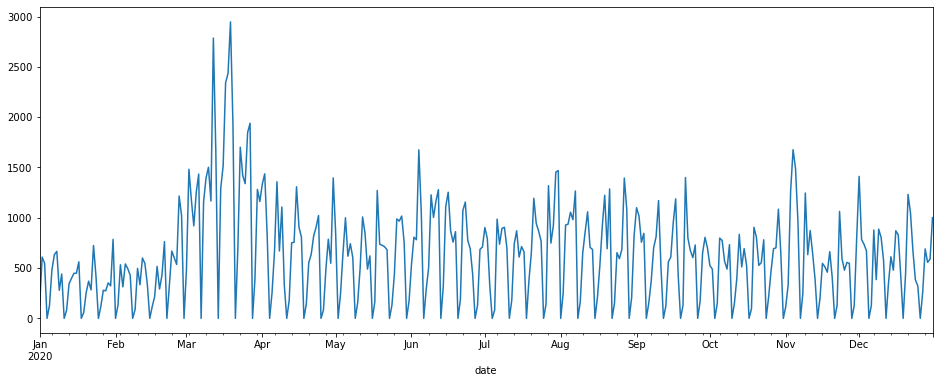

In [9]:
d1_quotes.volatility.plot(figsize=(16, 6))

Видно, что в какие-то из дней волатильность падает до нуля, причем с одинаковой периодичностью. И похоже, что это происходит раз в неделю. Посмотрим на зависимость от дня недели

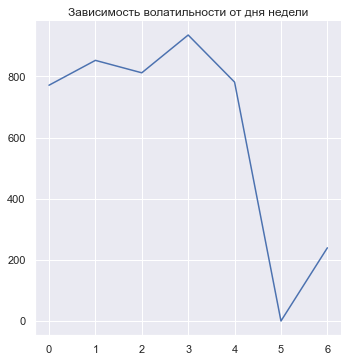

In [12]:
dur_by_weekday = d1_quotes.groupby(d1_quotes.index.weekday)
sns.set(font_scale=1)
sns.relplot(data=dur_by_weekday.volatility.aggregate('mean'), kind='line').\
    set(title='Зависимость волатильности от дня недели');

Провал на 5 и 6 соответствует котировкам в СБ и ВСК. При этом рынок в СБ и ВСК не работает. В ВСК может наблюдаться раннее открытие из-за новозеландской сессии, чем объясняет наличие некоторой активности в ВСК. Но она все еще сильно низкая, поэтому можно удалить котировки, соответствующие выходным дням.

### 3.2 Зависимости от новостей

<AxesSubplot:>

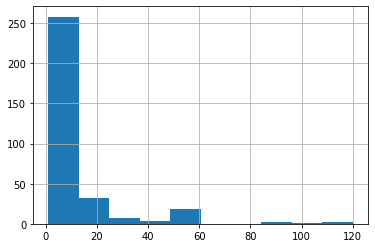

In [99]:
#распределение по числу разных новостей
news.title.value_counts().hist()

In [103]:
print('Всего новостей:', (news.title.value_counts()).count())
print('Единичных новостей:', (news.title.value_counts()==1).sum())

Всего новостей: 324
Единичных новостей: 47


Довольно много новостей, которые встречаются часто и которые можно отнести к регулярным. Но есть и уникальные новости и вероятно праздники. В дальнейшем можно с этим поработать и сгруппировать уникальные новости в подгруппы по силе и валюте.

Посмотрим, как часто встречались разные по силе новости для разных валют

In [122]:
#news = news[news.duplicated(subset=['title'], keep=False)]
news.groupby(['currency', 'impact']).title.agg(['count'])

count
currency impact       
EUR      HIGH      229
         LOW      1390
         MEDIUM    629
         NONE       48
USD      HIGH      238
         LOW      1243
         MEDIUM    854
         NONE       13

Видно, что больше всего новостей слабого влияния LOW, затем среднего MEDIUM. Меньше - сильных HIGH, и совсем мало - новостей без обозначенного влияния NONE (например, праздники). При этом соотношение числа новостей для подгрупп по валютам EUR и USD  сопоставимо.

Добавим колонки о силе новостей и валютной паре в датасет котировок, чтобы затем проанализировать зависимость от получившихся групп.
Выделим соответственно 8 новостных категорий (столбцов):
* EUR_NONE
* EUR_LOW
* EUR_MEDIUM
* EUR_HIGH
* USD_NONE
* USD_LOW
* USD_MEDIUM
* USD_HIGH

В значениях поставим число новостей данной категории в день.

In [174]:
d1_news = news
d1_news['news_cat'] = d1_news.currency + '_' + d1_news.impact
lst_news_cat = d1_news['news_cat'].unique() # используется позже
d1_news = pd.get_dummies(d1_news.news_cat).resample('D').sum()
d1 = d1_quotes.join(d1_news)
d1.head()

,Open,High,Low,Close,Volume,volatility,uptrend,EUR_HIGH,EUR_LOW,EUR_MEDIUM,EUR_NONE,USD_HIGH,USD_LOW,USD_MEDIUM,USD_NONE
date,,,,,,,,,,,,,,,
2020-01-01,1.12076,1.12218,1.12076,1.12188,2592.0700,141,True,0,0,0,0,0,0,0,1
2020-01-02,1.12188,1.12245,1.11635,1.11708,487219.1160,609,False,0,4,1,0,0,3,3,0
2020-01-03,1.11707,1.11798,1.11249,1.11548,177406.7897,548,False,1,9,2,0,2,6,4,0
2020-01-04,1.11548,1.11548,1.11548,1.11548,0.0000,0,False,0,0,0,0,0,0,0,0
2020-01-05,1.11548,1.11677,1.11548,1.11604,4398.1000,129,True,0,0,1,2,0,0,0,0


Зависимость волатильности и направления от кол-ва новостей в день

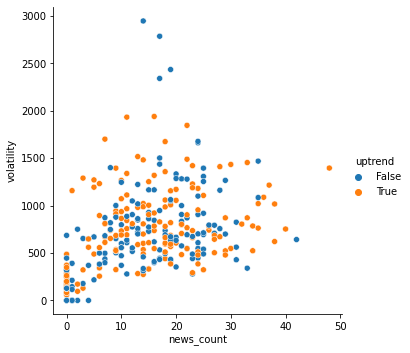

In [286]:
news_count = d1[lst_news_cat].sum(axis=1)
news_count.name = 'news_count'
sns.relplot(data=d1, x=news_count, y='volatility', hue='uptrend')

Волатильность ожидаемо растет с ростом числа новостей в день. Начиная со значения 5 и более новостей волатильность остается в одном диапозоне 600-800 пунктов в день с некоторым повышением до 1000 и больше пунктов, что чаще проявляется после с 28 новостей в день, но в целом дней с таким числом новостей уже мало.

Цветом выделены дни, закрывающиеся с повышением. Серьезной зависимости не наблюдается. "Бычьи дни" случаются при любом кол-ве новостей. Единственное, выбросы с большой волатильностью до 3000 пунктов в день в 2020 году были именно с понижением (синий цвет).

Зависимость волатильности и направления от валюты, по которой выходят новости

      uptrend  volatility
usd  0.601361  764.981501
eur  0.550035  813.784195


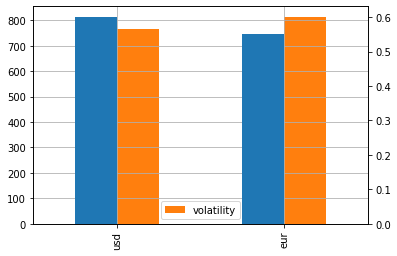

In [242]:
usd_pivot = d1.pivot_table(index=[d1['USD_NONE']+d1['USD_LOW']+d1['USD_MEDIUM']+d1['USD_HIGH']],\
    values=['volatility', 'uptrend'], aggfunc=['mean'])['mean'].mean()
eur_pivot = d1.pivot_table(index=[d1['EUR_NONE']+d1['EUR_LOW']+d1['EUR_MEDIUM']+d1['EUR_HIGH']],\
    values=['volatility', 'uptrend'], aggfunc=['mean'])['mean'].mean()
usd_pivot.name='usd'
eur_pivot.name='eur'
eur_usd_pivot = usd_pivot.to_frame().join(eur_pivot.to_frame()).T
print(eur_usd_pivot)
eur_usd_pivot.plot(kind='bar', secondary_y='uptrend', grid=True).legend(loc='best')

Видно, что в дни, когда выходят новости по EUR волатильность EUR/USD выше (814 > 765). При этом вероятность, что день закроется повышением цены, была в 2020 выше в те дни, когда выходят новости по USD (60% > 55%)

**Замечание**: в один и тот же день могут быть новости, как по EUR, так и по USD. Поэтому далее надо провести более чистый эксперимент. Например, более точной будет проверка на часовиках, создание коэффициента преобладания валюты в рассматриваемый период и др.

Зависимость от импакта новости. 

                  none         low      medium        high
uptrend       0.460732    0.542259    0.560482    0.672827
volatility  564.887753  802.097284  775.140665  905.719715


<AxesSubplot:>

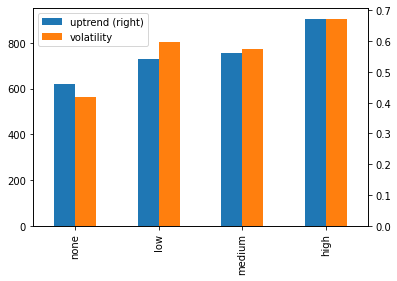

In [341]:
none_pivot = d1.pivot_table(index=[d1['USD_NONE']+d1['EUR_NONE']],\
    values=['volatility', 'uptrend'], aggfunc=['mean'])['mean'].mean().to_frame()
low_pivot = d1.pivot_table(index=[d1['USD_LOW']+d1['EUR_LOW']],\
    values=['volatility', 'uptrend'], aggfunc=['mean'])['mean'].mean().to_frame()
medium_pivot = d1.pivot_table(index=[d1['USD_MEDIUM']+d1['EUR_MEDIUM']],\
    values=['volatility', 'uptrend'], aggfunc=['mean'])['mean'].mean().to_frame()
high_pivot = d1.pivot_table(index=[d1['USD_HIGH']+d1['EUR_HIGH']],\
    values=['volatility', 'uptrend'], aggfunc=['mean'])['mean'].mean().to_frame()
impact_pivot = pd.concat([none_pivot, low_pivot, medium_pivot, high_pivot], axis=1)
impact_pivot.columns = ['none', 'low', 'medium', 'high']
print(impact_pivot)
impact_pivot.T.plot(kind='bar', secondary_y='uptrend')

Прослеживается рост волатильности и вероятности аптренда по мере роста номинального импакта новости. 

Проведем более деатльный разбор по категориям.

In [175]:
pivot_news = {}
for cat in lst_news_cat:
    pivot_news[cat] = d1.pivot_table(index=[cat],\
        values=['volatility', 'uptrend'], aggfunc=['mean'])['mean']

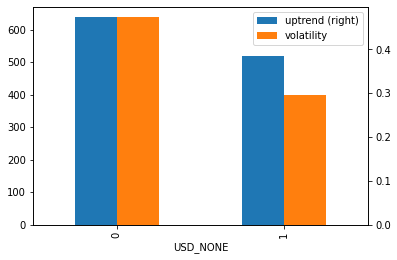

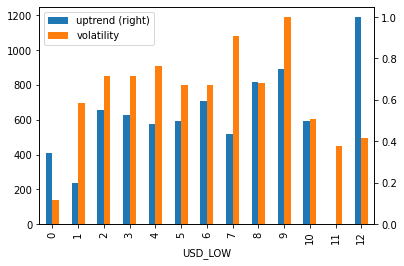

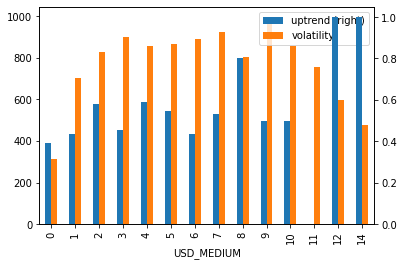

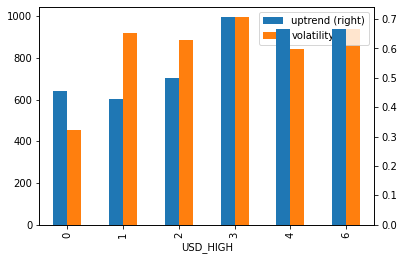

In [342]:
# для новостей USD
for cat in ('USD_NONE', 'USD_LOW', 'USD_MEDIUM', 'USD_HIGH'):
    pivot_news[cat].plot(kind='bar', secondary_y='uptrend')

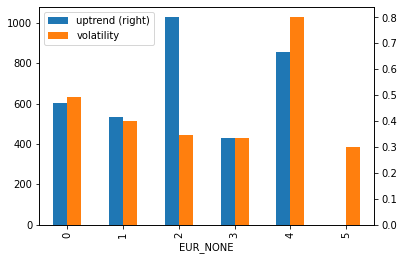

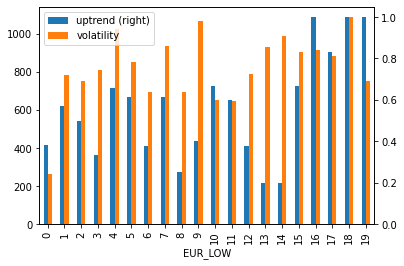

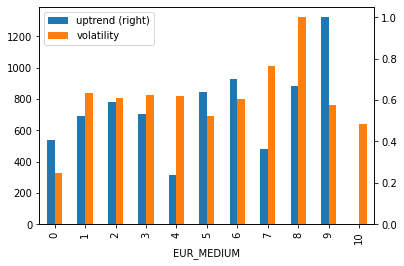

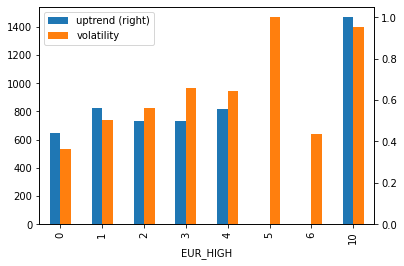

In [343]:
# для новостей EUR
for cat in ('EUR_NONE', 'EUR_LOW', 'EUR_MEDIUM', 'EUR_HIGH'):
    pivot_news[cat].plot(kind='bar', secondary_y='uptrend')

Для категорий LOW, MEDIUM, HIGH почти всегда видим рост волатильности по мере увеличения числа, как EUR-, так и USD-новостей.

В целом, с ростом числа новостей и с ростом импакта растет волатильность внутри дня.

Для дальнейшего исследования предлагается рассмотреть часовой (или ниже) таймфрейм и конкретные регулярные новости, что позволит более точно обнаружить взаимосвязь повторяющихся новостей с волатильностью и направлением.

Предполагается, что работа поможет пересмотреть влияние ряда новостей на волатильность рынка. Как минимум, можно будет сделать выводы по влиянию топа регулярных новостей

In [345]:
news.title.value_counts().head(20)

Markit Manufacturing PMI                 120
Markit Services PMI                      120
Consumer Price Index (YoY)               108
Consumer Price Index (MoM)                96
Markit PMI Composite                      96
Consumer Confidence                       59
Initial Jobless Claims                    53
EIA Crude Oil Stocks Change               53
4-Week Bill Auction                       53
EIA Natural Gas Storage Change            53
Baker Hughes US Oil Rig Count             53
Initial Jobless Claims 4-week average     53
Continuing Jobless Claims                 53
CFTC EUR NC Net Positions                 52
Redbook Index (MoM)                       52
Redbook Index (YoY)                       52
CFTC Oil NC Net Positions                 52
CFTC Gold NC Net Positions                52
API Weekly Crude Oil Stock                52
3-Month Bill Auction                      51
Name: title, dtype: int64

### Продолжение следует...